In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")
all_images = fd_collection.find()

In [5]:
selected_latent_space = valid_latent_spaces[
    str(input("Enter latent space - one of " + str(list(valid_latent_spaces.keys()))))
]

selected_feature_model = valid_feature_models[
    str(input("Enter feature model - one of " + str(list(valid_feature_models.keys()))))
]

k = int(input("Enter value of k (no. of latent semantics): "))
if k < 1:
    raise ValueError("k should be a positive integer")

k_2 = int(input("Enter value of k_2 (no. of similar images): "))
if k_2 < 1:
    raise ValueError("k_2 should be a positive integer")

if selected_latent_space != "cp":
    selected_dim_reduction_method = str(
        input(
            "Enter dimensionality reduction method - one of "
            + str(list(valid_dim_reduction_methods.keys()))
        )
    )

label = int(input("Enter label: "))
if label < 0 and label > 100:
    raise ValueError("label should be between 0 and 100")

label_rep = calculate_label_representatives(
    fd_collection, label, selected_feature_model
)


In [6]:
# Loading latent semantics
match selected_latent_space:
    # LS1
    case "":
        file_prefix = f"{selected_feature_model}-{selected_dim_reduction_method}-{k}"
        file_name = file_prefix + "-semantics.json"
        model_name = file_prefix + "-model.joblib"
        if os.path.exists(file_name):
            data = json.load(open(file_name))
            print(file_name + " loaded")
        else:
            raise Exception(file_name + " does not exist")
        # LDA model
        if selected_dim_reduction_method == "lda":
            if os.path.exists(model_name):
                data_model = load(model_name)
                print(model_name + " loaded")
            else:
                raise Exception(model_name + " does not exist")
    # LS2
    case "cp":
        file_name = f"{selected_feature_model}-cp-{k}-semantics.json"
        if os.path.exists(file_name):
            data = json.load(open(file_name))
            print(file_name + " loaded")
        else:
            raise Exception(file_name + " does not exist")
    # LS3, LS4
    case _:
        file_name = f"{selected_latent_space}-{selected_feature_model}-{selected_dim_reduction_method}-{k}-semantics.json"
        if os.path.exists(file_name):
            data = json.load(open(file_name))
            print(file_name + " loaded")
        else:
            raise Exception(file_name + " does not exist")


cm_fd-svd-10-semantics.json loaded


In [7]:
def extract_similarities_ls1_ls4(latent_space, dim_reduction, data, label, label_rep):
    match dim_reduction:
        case "svd":
            U = np.array(data["image-semantic"])
            S = np.array(data["semantics-core"])
            if len(S.shape) == 1:
                S = np.diag(S)
            V = np.transpose(np.array(data["semantic-feature"]))

            if latent_space == "image_sim":
                label_vectors = []
                length = len(U)
                # get label rep from img sim matrix itself
                # i.e get label's images' semantics and take rep from those
                for i in range(length):
                    if all_images[i]["true_label"] == label:
                        label_vectors.append(U[i])
                label_rep = [sum(col) / len(col) for col in zip(*label_vectors)]
                comparison_vector = np.matmul(label_rep, S)
            else:
                # use label rep from feature space
                comparison_vector = np.matmul(np.matmul(label_rep, V), S)

            comparison_feature_space = np.matmul(U, S)

        case "nmf":
            H = np.array(data["semantic-feature"])
            comparison_feature_space = W = np.array(data["image-semantic"])
            if latent_space == "image_sim":
                label_vectors = []
                length = len(W)
                for i in range(length):
                    if all_images[i]["true_label"] == label:
                        label_vectors.append(W[i])
                label_rep = [sum(col) / len(col) for col in zip(*label_vectors)]
                comparison_vector = label_rep
            else:
                min_value = np.min(label_rep)
                feature_vectors_shifted = label_rep - min_value
                comparison_vector = nmf(feature_vectors_shifted, H, update_H=False)

        case "kmeans":
            comparison_vector = []
            comparison_feature_space = np.array(data["image-semantic"])
            S = np.array(data["semantic-feature"])

            if latent_space == "image_sim":
                sim_matrix = np.array(data["sim-matrix"])
                label_vectors = []
                length = len(sim_matrix)
                for i in range(length):
                    if all_images[i]["true_label"] == label:
                        label_vectors.append(sim_matrix[i])
                label_rep = [sum(col) / len(col) for col in zip(*label_vectors)]

            # get label_rep's kmeans semantic
            for centroid in S:
                comparison_vector.append(math.dist(label_rep, centroid))

        case "lda":

            comparison_feature_space = np.array(data["image-semantic"])
            if latent_space == "image_sim":
                label_vectors = []
                length = len(comparison_feature_space)
                for i in range(length):
                    if all_images[i]["true_label"] == label:
                        label_vectors.append(comparison_feature_space[i])
                label_rep = [sum(col) / len(col) for col in zip(*label_vectors)]
                comparison_vector = label_rep
            else:
                min_value = np.min(label_rep)
                feature_vectors_shifted = label_rep - min_value
                comparison_vector = data_model.transform(
                    feature_vectors_shifted.flatten().reshape(1, -1)
                ).flatten()

    distances = []
    for i in range(NUM_IMAGES):
        if all_images[i]["true_label"] != label:
            if dim_reduction == "lda":
                # KL divergence
                distances.append(
                    {
                        "image_id": i * 2,
                        "label": all_images[i]["true_label"],
                        "distance": kl_divergence_measure(
                            comparison_vector, comparison_feature_space[i]
                        ),
                    }
                )
            else:
                # euclidean
                distances.append(
                    {
                        "image_id": i * 2,
                        "label": all_images[i]["true_label"],
                        "distance": math.dist(
                            comparison_vector, comparison_feature_space[i]
                        ),
                    }
                )

    distances = sorted(distances, key=lambda x: x["distance"], reverse=False)

    most_similar_labels = []
    unique_labels = set()

    for img in distances:
        if img["label"] not in unique_labels:
            most_similar_labels.append(img)
            unique_labels.add(img["label"])

            if len(most_similar_labels) == k_2:
                break

    return most_similar_labels


In [8]:
def extract_similarities_ls2(data, label):
    LS = np.array(data["label-semantic"])
    S = np.array(data["semantics-core"])

    if len(S.shape) == 1:
        S = np.diag(S)

    comparison_feature_space = np.matmul(LS, S)
    comparison_vector = comparison_feature_space[label]

    most_similar_labels = []

    n = len(comparison_feature_space)
    for i in range(n):
        if i != label:
            most_similar_labels.append(
                {
                    "label": i,
                    "distance": math.dist(
                        comparison_vector, comparison_feature_space[i]
                    ),
                }
            )

    most_similar_labels = sorted(
        most_similar_labels, key=lambda x: x["distance"], reverse=False
    )[:k_2]

    return most_similar_labels


In [9]:
def extract_similarities_ls3(dim_reduction, data, label):

    if dim_reduction == "svd":
        U = np.array(data["image-semantic"])
        S = np.array(data["semantics-core"])

        comparison_feature_space = np.matmul(U, S)
    else:
        comparison_feature_space = np.array(data["image-semantic"])

    comparison_vector = comparison_feature_space[label]

    n = len(comparison_feature_space)
    most_similar_labels = []
    for i in range(n):
        if i != label:
            if dim_reduction == "lda":
                most_similar_labels.append(
                    {
                        "label": i,
                        "distance": math.dist(
                            comparison_vector, comparison_feature_space[i]
                        ),
                    }
                )
            else:
                most_similar_labels.append(
                    {
                        "label": i,
                        "distance": kl_divergence_measure(
                            comparison_vector, comparison_feature_space[i]
                        ),
                    }
                )

    most_similar_labels = sorted(
        most_similar_labels, key=lambda x: x["distance"], reverse=False
    )[:k_2]

    return most_similar_labels


In [10]:
match selected_latent_space:
    case "" | "image_sim":
        result = extract_similarities_ls1_ls4(
            selected_latent_space, selected_dim_reduction_method, data, label, label_rep
        )
    case "label_sim":
        result = extract_similarities_ls3(selected_dim_reduction_method, data, label)
    case "cp":
        result = extract_similarities_ls2(data, label)


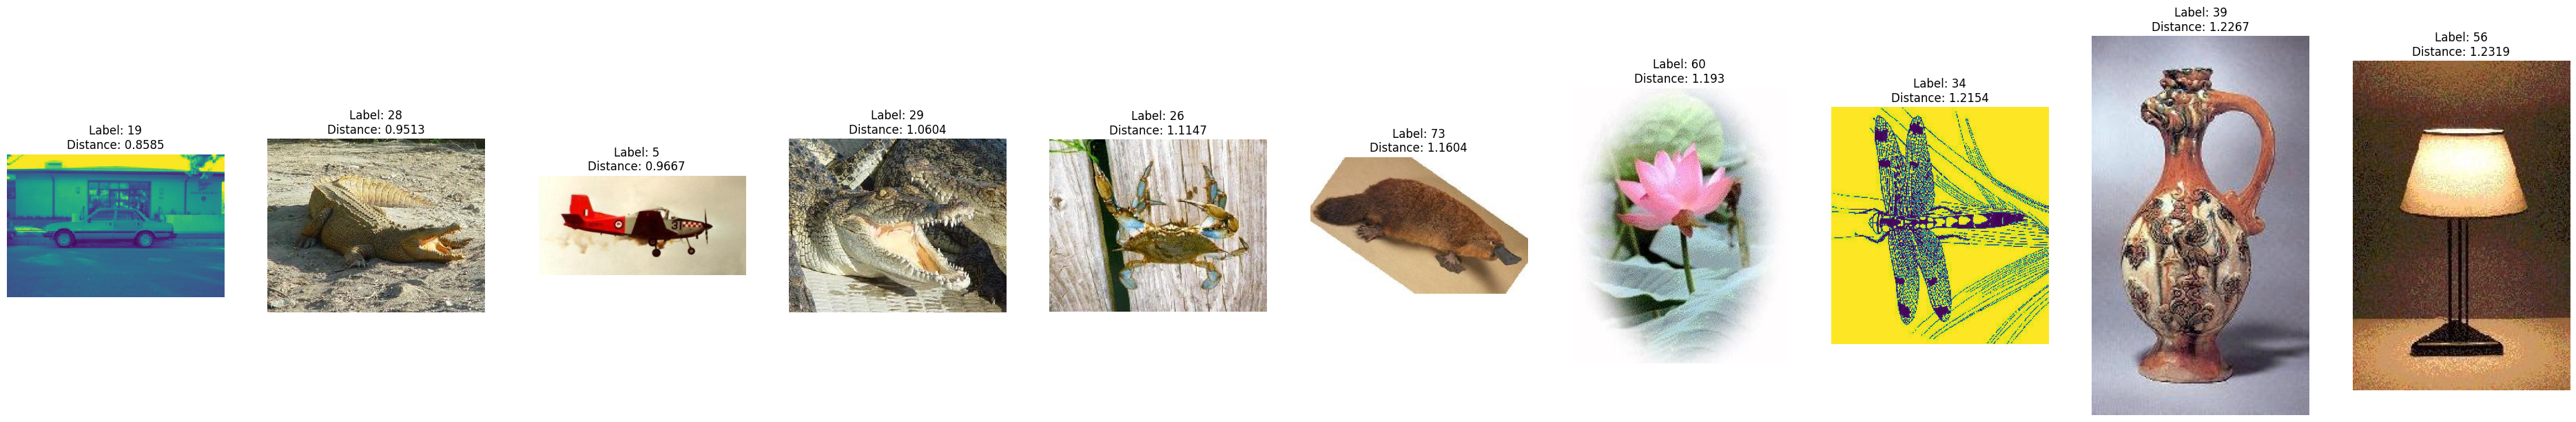

In [11]:
fig, axs = plt.subplots(1, k_2, figsize=(48, 12))
# display one image from each label
for idx, label_data in enumerate(result):
    img = fd_collection.find_one({"true_label": label_data["label"]})
    cur_img, _ = dataset[img["image_id"]]
    axs[idx].imshow(transforms.ToPILImage()(cur_img))
    axs[idx].set_title(
        "Label: {}\nDistance: {}".format(
            label_data["label"], round(label_data["distance"], 4)
        )
    )
    axs[idx].axis("off")
plt.show()
